## Importing Packages and Data

### Importing Packages

In [1]:
from keras.utils import to_categorical
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from matplotlib import image
from matplotlib import pyplot
import pandas as pd
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, f1_score
from keras import layers
from keras import models
from keras import regularizers
from collections import Counter

Using TensorFlow backend.


### Importing Data

In [2]:
train_data_dir = '../Mod 6 Project/gtsrb-german-traffic-sign/Train'
test_data_dir = '../Mod 6 Project/gtsrb-german-traffic-sign/Test 2'

In [3]:
train_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
                    train_data_dir,
                    target_size=(64,64),
                    classes=[str(i) for i in np.arange(43)],
                    batch_size=39209)

test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
                    test_data_dir,
                    target_size=(64,64),
                    classes=[],
                    batch_size=12630)

Found 39209 images belonging to 43 classes.
Found 12630 images belonging to 1 classes.


In [4]:
train_data, train_labels = next(train_batches)
test_data, test_labels = next(test_batches)

## Processing Data

### Making Labels

In [5]:
train_labels_good = np.array([list(img).index(1.0) for img in train_labels])

In [6]:
df = pd.read_csv('gtsrb-german-traffic-sign/test.csv')
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [7]:
path_test = [int(i.replace('Test/','').replace('.png','')) for i in list(df['Path'])]
id_test = list(df['ClassId'])
path_id = dict(zip(path_test, id_test))
labels = [path_id[batch] for batch in list(test_batches.index_array)]
test_labels_good = np.array(labels)

In [8]:
train_labels_final = to_categorical(train_labels_good)
test_labels_final = to_categorical(test_labels_good)

### Verifying our Data

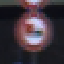

In [9]:
array_to_img(test_data[0])

In [10]:
test_labels_good[0]

10

In [11]:
print(np.shape(train_data))
print(np.shape(train_labels_final))
print(np.shape(test_data))
print(np.shape(test_labels_final))

(39209, 64, 64, 3)
(39209, 43)
(12630, 64, 64, 3)
(12630, 43)


## Running the Neural Network

### Making the Network

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(43, activation='softmax'))

In [13]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

### Model Validation 

In [14]:
x_val = train_data[:3000]
partial_x_train = train_data[3000:]
y_val = train_labels[:3000]
partial_y_train = train_labels[3000:]

### Running the Model

In [15]:
history = model.fit(partial_x_train, partial_y_train, epochs=20,batch_size=250,validation_data=(x_val, y_val))

Train on 36209 samples, validate on 3000 samples
Epoch 1/20
36209/36209 [==============================] - 130s 4ms/step - loss: 2.0804 - accuracy: 0.4495 - val_loss: 0.7103 - val_accuracy: 0.7923
Epoch 2/20
36209/36209 [==============================] - 133s 4ms/step - loss: 0.3720 - accuracy: 0.8957 - val_loss: 0.2043 - val_accuracy: 0.9447
Epoch 3/20
36209/36209 [==============================] - 129s 4ms/step - loss: 0.1569 - accuracy: 0.9597 - val_loss: 0.1294 - val_accuracy: 0.9650
Epoch 4/20
36209/36209 [==============================] - 132s 4ms/step - loss: 0.0832 - accuracy: 0.9783 - val_loss: 0.0863 - val_accuracy: 0.9770
Epoch 5/20
36209/36209 [==============================] - 133s 4ms/step - loss: 0.0519 - accuracy: 0.9874 - val_loss: 0.0812 - val_accuracy: 0.9797
Epoch 6/20
36209/36209 [==============================] - 130s 4ms/step - loss: 0.0388 - accuracy: 0.9902 - val_loss: 0.0747 - val_accuracy: 0.9823
Epoch 7/20
36209/36209 [==============================] - 132s 

### Assessing the Model

In [16]:
test_loss, test_acc = model.evaluate(test_data, test_labels_final)
test_acc

12630/12630 [==============================] - 16s 1ms/step


0.9430720210075378

In [17]:
predictions_transfer = model.predict(test_data)
predictions_transfer = np.around(predictions_transfer)
f1_score(test_labels_final, predictions_transfer, average='micro')

0.9435893367185022

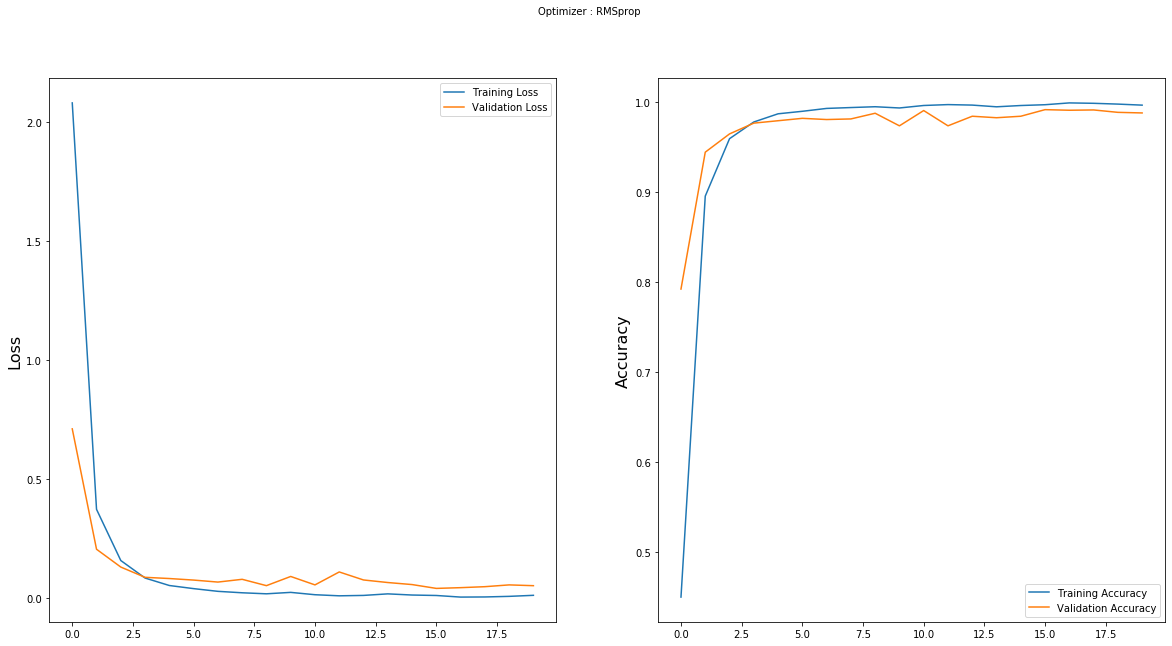

In [18]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : RMSprop', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

## Interpreting the Misclassifications

In [23]:
wrong_preds = []
for i in range(len(test_labels_final)):
    if np.argmax(test_labels_final[i]) ==  np.argmax(predictions_transfer[i]):
        continue
    else:
        wrong_preds.append(i)

In [40]:
error_tuples = []
for i in wrong_preds:
    try:
        label = list(test_labels_final[i]).index(1.)
        predict = list(predictions_transfer[i]).index(1.)
        atuple = (label,predict)
        error_tuples.append(atuple)
    except:
        continue

In [41]:
cnt = Counter()
for word in error_tuples:
    cnt[word] += 1

In [43]:
error_pairs = {k: v for k, v in sorted(cnt.items(), key=lambda item: item[1])}

In [59]:
error_pairs

{(1, 7): 1,
 (10, 19): 1,
 (4, 13): 1,
 (23, 31): 1,
 (8, 1): 1,
 (5, 9): 1,
 (41, 28): 1,
 (8, 7): 1,
 (39, 33): 1,
 (31, 25): 1,
 (26, 41): 1,
 (14, 17): 1,
 (3, 41): 1,
 (7, 15): 1,
 (20, 30): 1,
 (11, 30): 1,
 (31, 39): 1,
 (7, 5): 1,
 (23, 28): 1,
 (41, 15): 1,
 (26, 1): 1,
 (1, 4): 1,
 (16, 8): 1,
 (38, 37): 1,
 (1, 0): 1,
 (16, 20): 1,
 (42, 5): 1,
 (22, 26): 1,
 (11, 23): 1,
 (1, 25): 1,
 (13, 24): 1,
 (40, 12): 1,
 (30, 17): 1,
 (42, 32): 1,
 (39, 37): 1,
 (10, 23): 1,
 (18, 22): 1,
 (7, 20): 1,
 (1, 9): 1,
 (18, 21): 1,
 (11, 9): 1,
 (28, 24): 1,
 (31, 29): 1,
 (5, 10): 1,
 (27, 0): 1,
 (13, 25): 1,
 (31, 8): 1,
 (30, 3): 1,
 (10, 5): 1,
 (33, 39): 1,
 (22, 37): 1,
 (1, 18): 1,
 (10, 18): 1,
 (29, 22): 1,
 (1, 17): 1,
 (9, 23): 1,
 (17, 15): 1,
 (22, 27): 1,
 (1, 8): 1,
 (11, 32): 1,
 (4, 3): 1,
 (5, 31): 1,
 (40, 11): 1,
 (40, 6): 1,
 (4, 15): 1,
 (38, 13): 1,
 (30, 28): 1,
 (28, 25): 1,
 (21, 30): 1,
 (12, 38): 1,
 (6, 41): 1,
 (15, 1): 1,
 (8, 38): 1,
 (34, 40): 1,
 (17, 1

In [70]:
error = pd.DataFrame(error_tuples, columns = ['Label', 'Predicted'])
error.head()

,Label,Predicted
0,4,8
1,1,7
2,7,8
3,25,27
4,8,2


In [80]:
error.groupby('Label').count()

,Predicted
Label,
0,8
1,13
2,9
3,9
4,47
5,49
6,30
7,67
8,6


In [77]:
#No errors labeling 16
error.groupby('Predicted').count()

,Label
Predicted,
0,5
1,30
2,36
3,60
4,1
5,26
6,1
7,8
8,82


Predicted
0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
1     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
2     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
3     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
4     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
5     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
6     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
7     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
8     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
9     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
10    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
11    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
12    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
13    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
15    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
17    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
18    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
19    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
20    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
21    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
22    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
23 

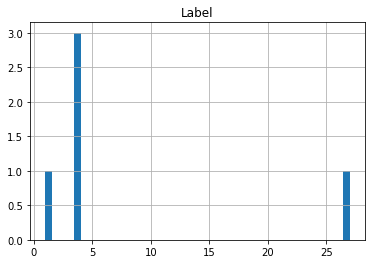

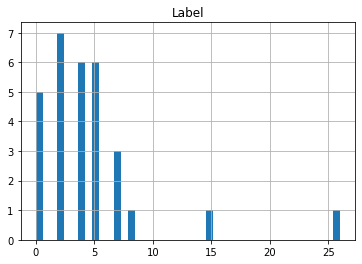

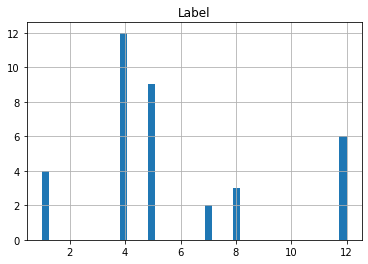

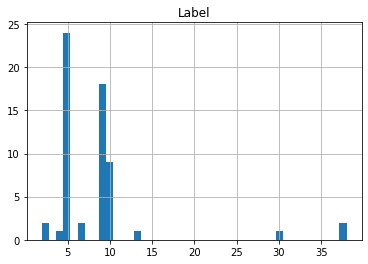

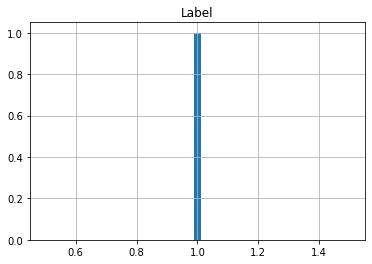

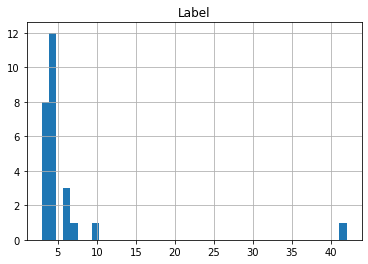

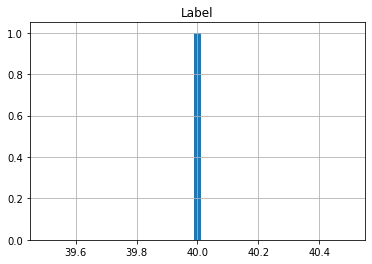

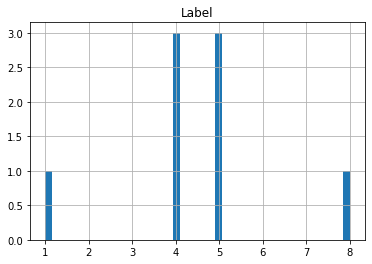

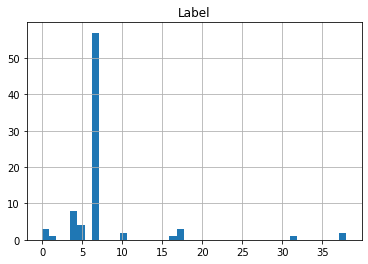

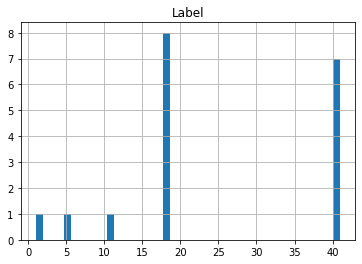

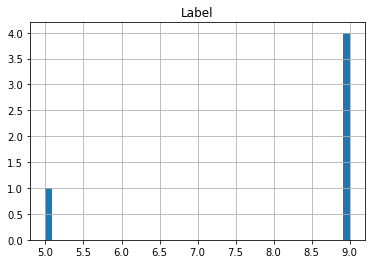

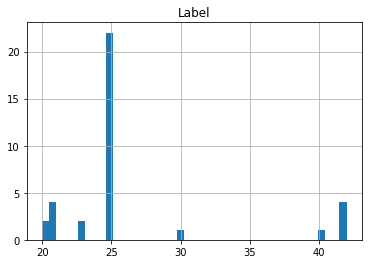

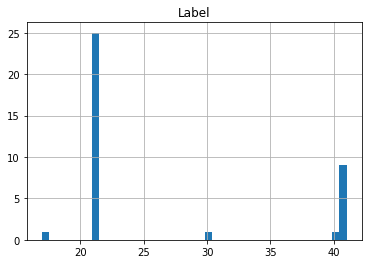

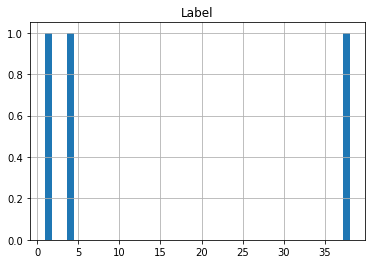

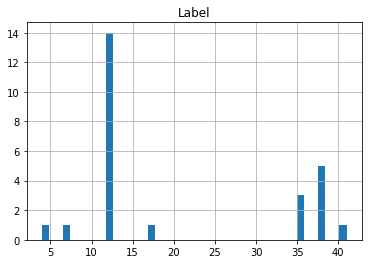

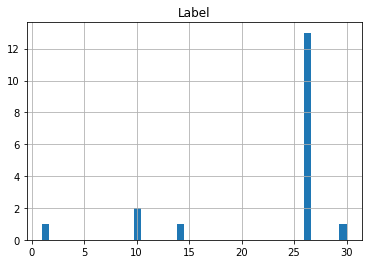

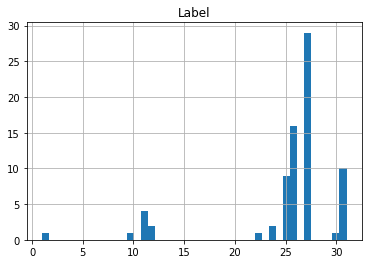

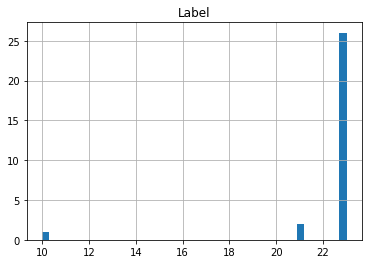

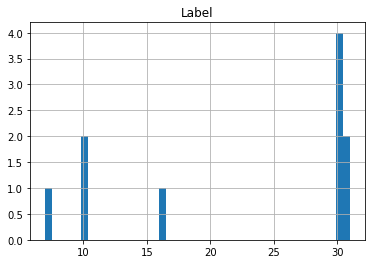

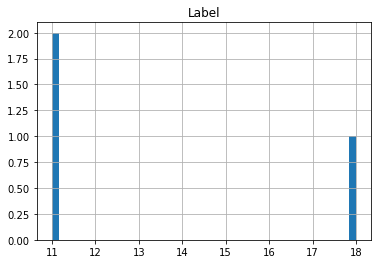

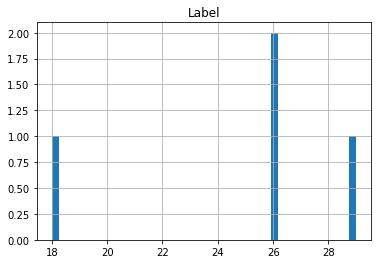

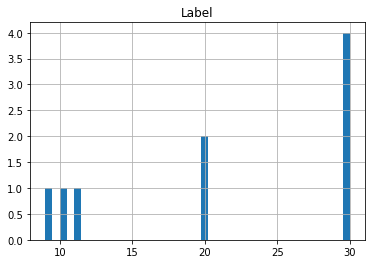

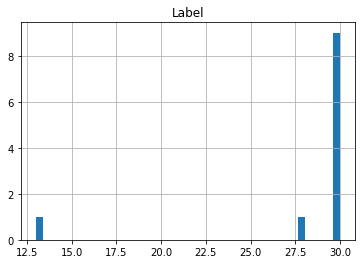

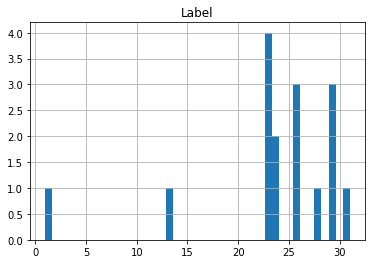

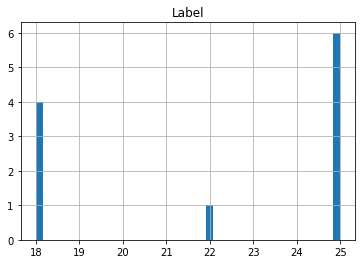

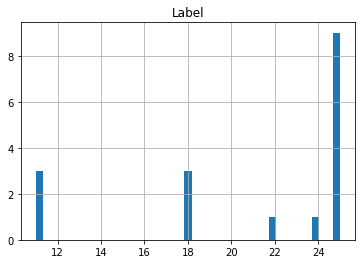

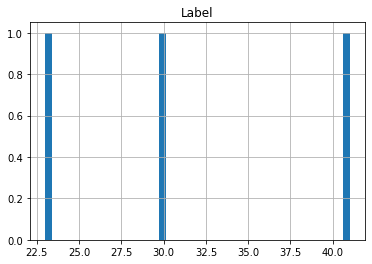

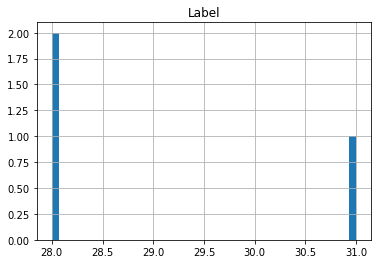

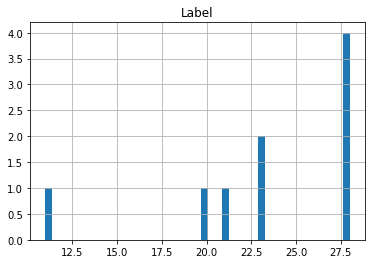

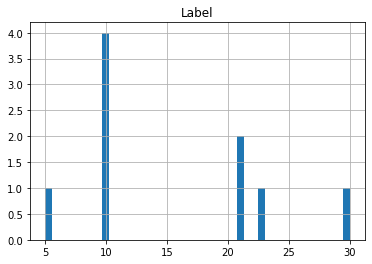

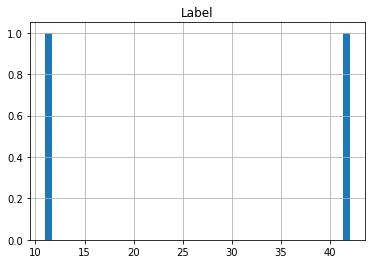

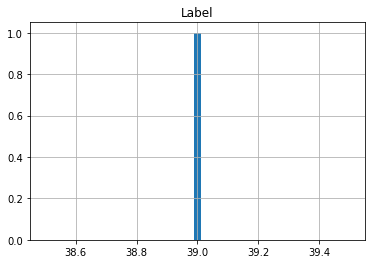

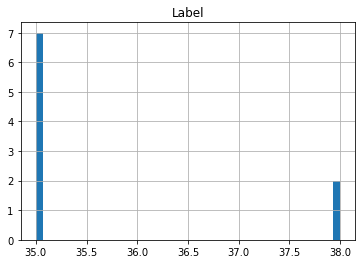

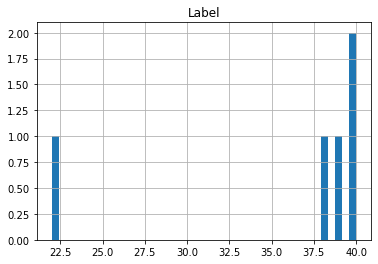

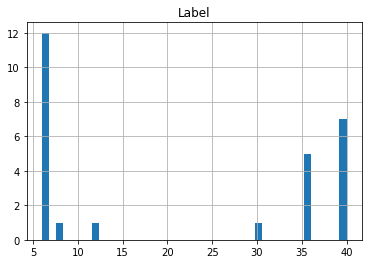

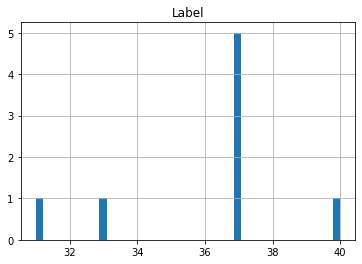

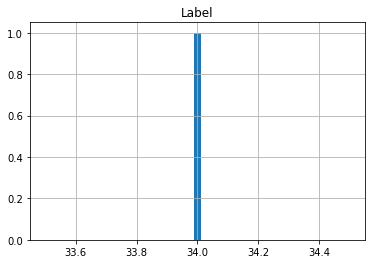

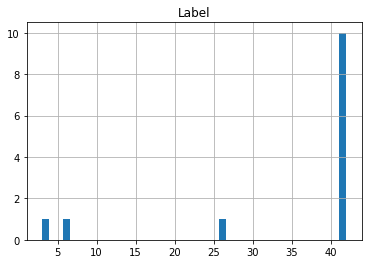

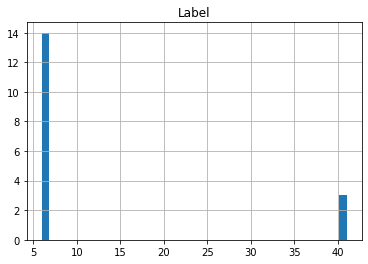

In [97]:
error.groupby('Predicted').hist(bins=43)

Label
0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
1     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
2     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
3     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
4     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
5     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
6     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
7     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
8     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
9     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
10    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
11    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
12    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
13    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
14    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
15    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
16    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
17    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
18    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
20    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
21    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
22    [

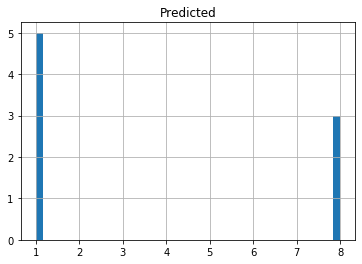

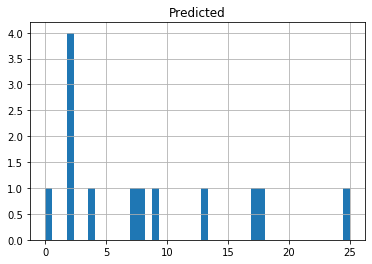

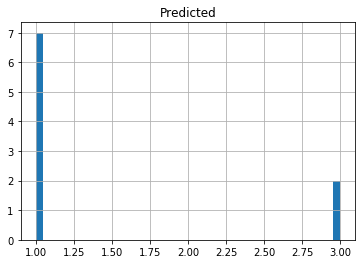

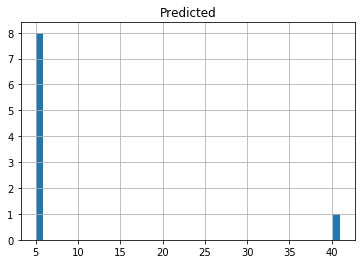

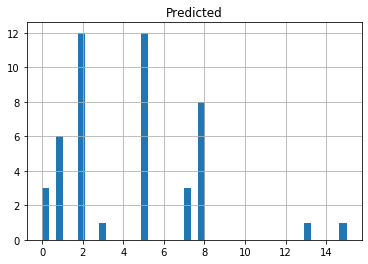

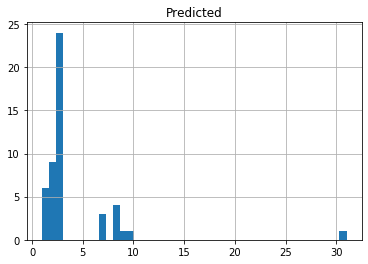

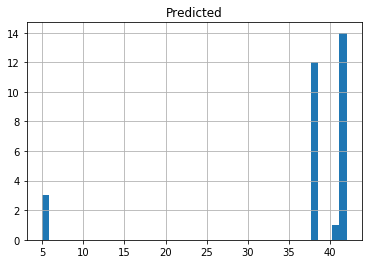

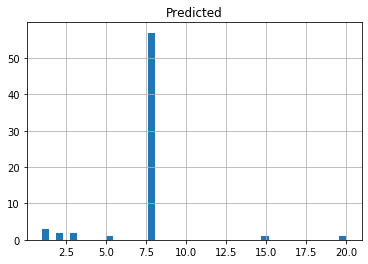

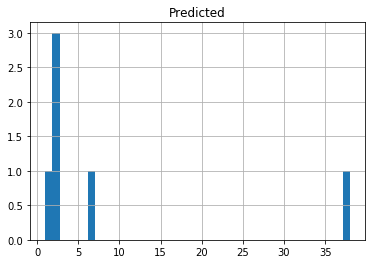

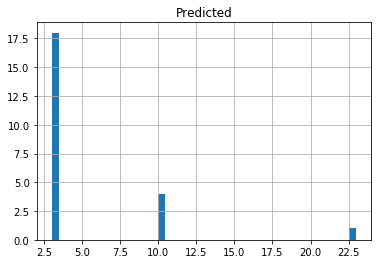

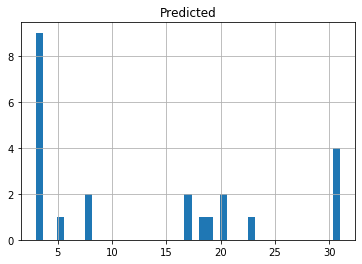

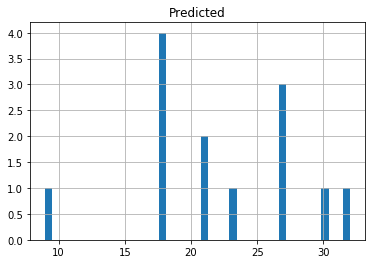

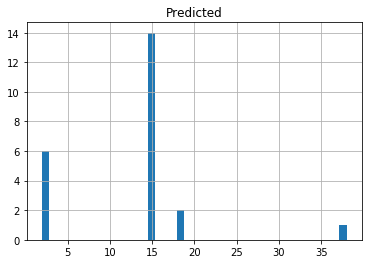

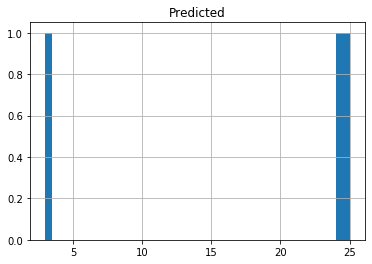

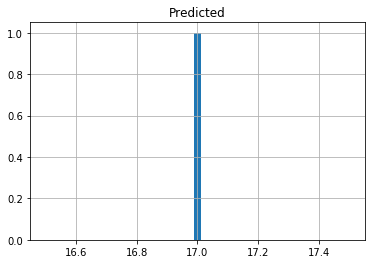

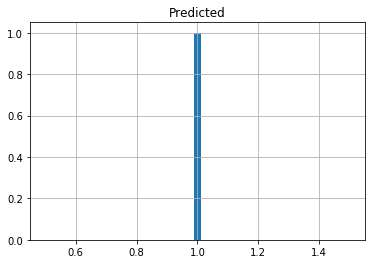

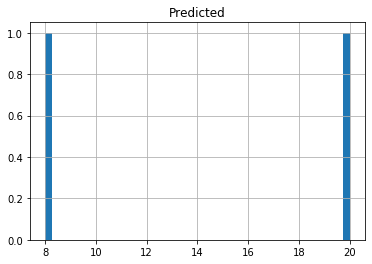

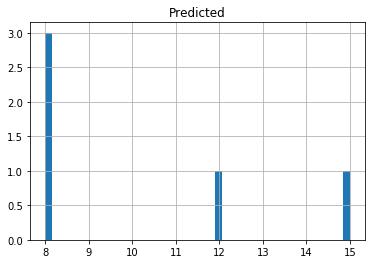

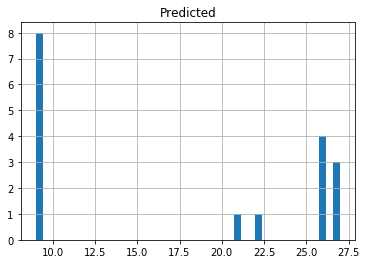

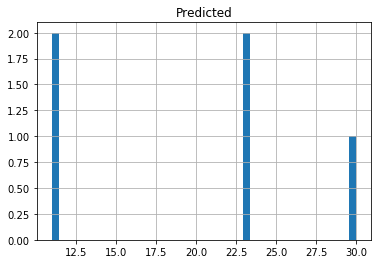

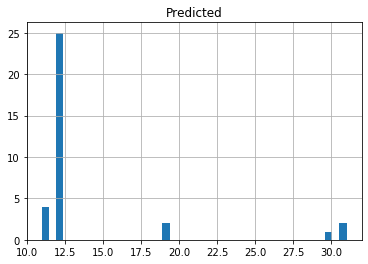

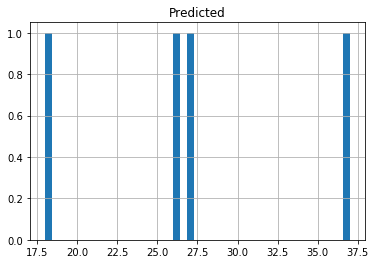

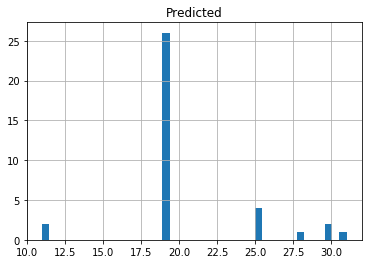

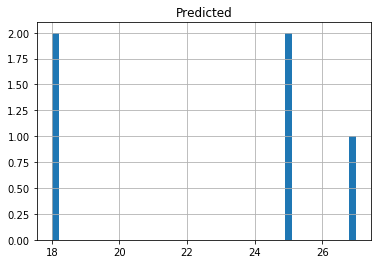

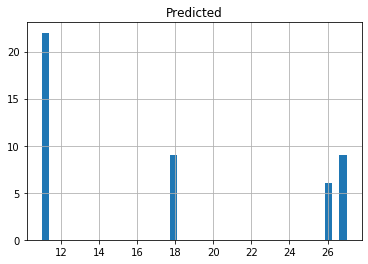

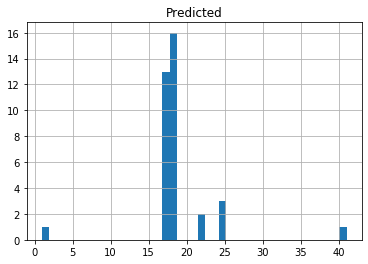

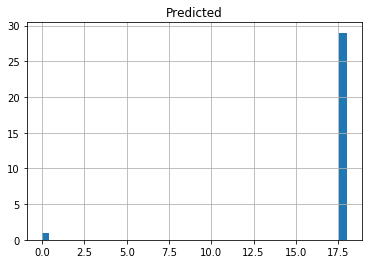

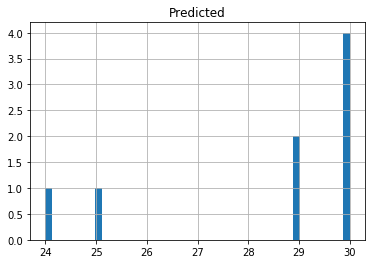

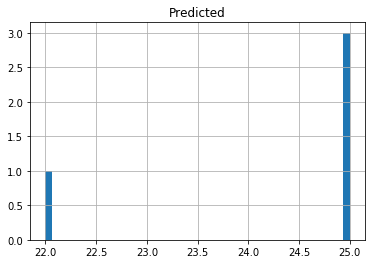

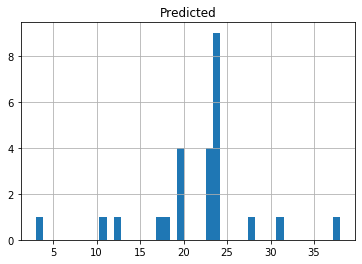

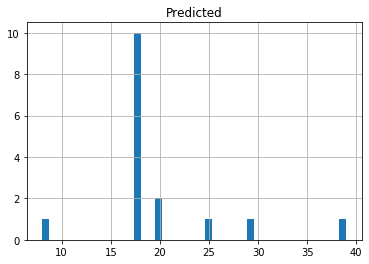

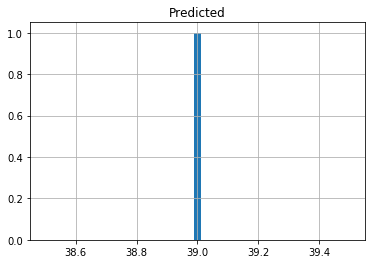

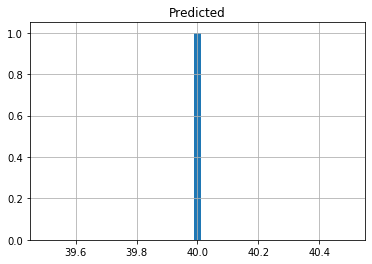

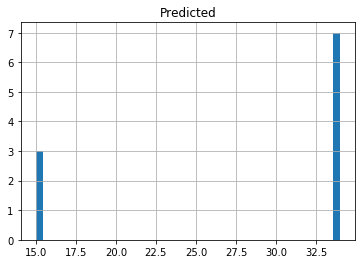

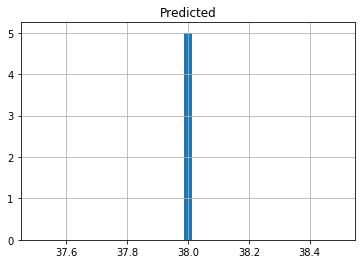

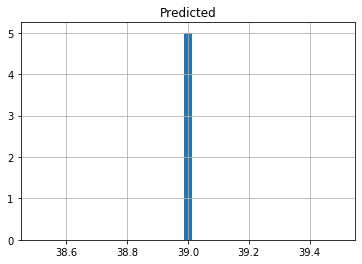

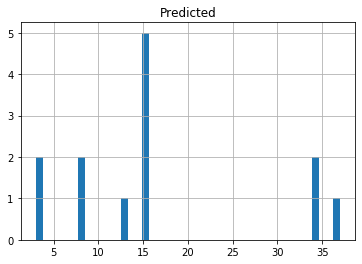

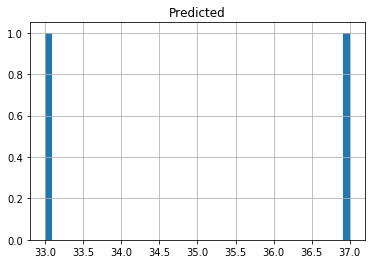

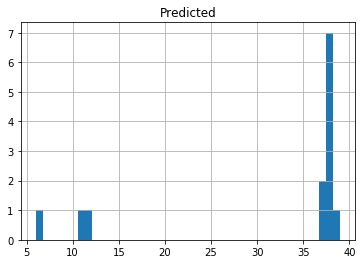

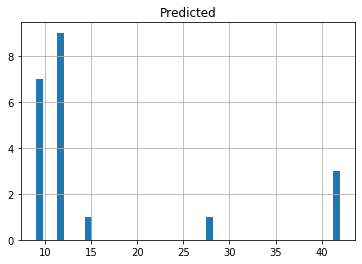

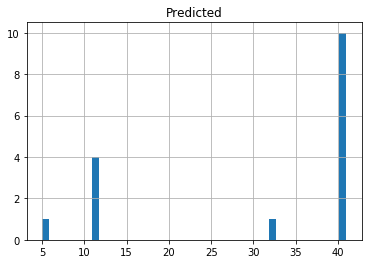

In [98]:
error.groupby('Label').hist(bins=43)